In [50]:
pip install pandas numpy joblib datamol rdkit scikit-learn xgboost lightgbm catboost ngboost seaborn chemplot umap-learn shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import warnings
import joblib
import pandas as pd
import numpy as np
import datamol as dm
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, AllChem
from sklearn.model_selection import train_test_split, ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
def remove_zero_variance_features(data):
    selector = VarianceThreshold()
    selector.fit(data)
    retained_columns =  data.columns[selector.get_support()]
    dropped_columns =  data.columns[~selector.get_support()]
    print(f"{len(dropped_columns)} columns dropped because of zero variance features: {dropped_columns.tolist()}")
    return data[retained_columns]

def remove_collinear_features(data, threshold):
    corr_matrix = data.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"{len(to_drop)} columns dropped because of correlation greater than {threshold}: {to_drop}")
    return data.drop(columns=to_drop, axis=1, inplace=False)

def scale_features_standard(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

def scale_features_minmax(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

def scale_targets_standard(data):
    scaler = StandardScaler()
    data_array = data.values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data_array)
    return pd.DataFrame(scaled_data, columns=[data.columns]), scaler

def scale_targets_minmax(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_array = data.values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data_array)
    return pd.DataFrame(scaled_data, columns=[data.columns]), scaler

In [3]:
df_X1_reactant = pd.read_csv('reactantfeats_morfeusdesc.csv', index_col=False)
df_X1_ts = pd.read_csv('tsfeats_morfeusdesc.csv', index_col=False)
df_X1_product = pd.read_csv('productfeats_morfeusdesc.csv', index_col=False)
df_X2_reactant = pd.read_csv('reactantfeats_mordreddesc.csv', usecols=['Datapoint','TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9'], index_col=False)
df_X2_ts = pd.read_csv('tsfeats_mordreddesc.csv', usecols=['Datapoint','TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9'], index_col=False)
df_X2_product = pd.read_csv('productfeats_mordreddesc.csv', usecols=['Datapoint','TPSA','PEOE_VSA1','PEOE_VSA2','PEOE_VSA3','PEOE_VSA4','PEOE_VSA5','PEOE_VSA6','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','PEOE_VSA10','PEOE_VSA11','PEOE_VSA12','PEOE_VSA13','SMR_VSA1','SMR_VSA2','SMR_VSA3','SMR_VSA4','SMR_VSA5','SMR_VSA6','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA2','SlogP_VSA3','SlogP_VSA4','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','SlogP_VSA10','SlogP_VSA11','EState_VSA1','EState_VSA2','EState_VSA3','EState_VSA4','EState_VSA5','EState_VSA6','EState_VSA7','EState_VSA8','EState_VSA9','EState_VSA10','VSA_EState1','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9'], index_col=False)
#df_X3_reactant = pd.read_csv('wrtprecomplex_refDZ.csv', usecols=['Datapoint', 'eR', 'GR'], index_col=False)
#df_X3_ts = pd.read_csv('wrtprecomplex_refDZ.csv', usecols=['Datapoint', 'eTS', 'GTS'], index_col=False)
#df_X3_product = pd.read_csv('wrtprecomplex_refDZ.csv', usecols=['Datapoint', 'eP', 'GP'], index_col=False)
#df_X3_reactant.rename(columns={'eR': 'e_refDZ', 'GR': 'G_refDZ'}, inplace=True)
#df_X3_ts.rename(columns={'eTS': 'e_refDZ', 'GTS': 'G_refDZ'}, inplace=True)
#df_X3_product.rename(columns={'eP': 'e_refDZ', 'GP': 'G_refDZ'}, inplace=True)
df_X3_reactant = pd.read_csv('wrtprecomplex_pm7.csv', usecols=['Datapoint', 'eR', 'GR', 'HR', 'freqR', 'irR', 'dipoleR'], index_col=False)
df_X3_ts = pd.read_csv('wrtprecomplex_pm7.csv', usecols=['Datapoint', 'eTS', 'GTS', 'HTS', 'freqTS', 'irTS', 'dipoleTS'], index_col=False)
df_X3_product = pd.read_csv('wrtprecomplex_pm7.csv', usecols=['Datapoint', 'eP', 'GP', 'HP', 'freqP', 'irP', 'dipoleP'], index_col=False)
df_X3_reactant.rename(columns={'eR': 'e_PM7', 'GR': 'G_PM7', 'HR': 'H_PM7', 'freqR': 'freq_PM7', 'irR': 'ir_PM7', 'dipoleR': 'dipole_PM7'}, inplace=True)
df_X3_ts.rename(columns={'eTS': 'e_PM7', 'GTS': 'G_PM7', 'HTS': 'H_PM7', 'freqTS': 'freq_PM7', 'irTS': 'ir_PM7', 'dipoleTS': 'dipole_PM7'}, inplace=True)
df_X3_product.rename(columns={'eP': 'e_PM7', 'GP': 'G_PM7', 'HP': 'H_PM7', 'freqP': 'freq_PM7', 'irP': 'ir_PM7', 'dipoleP': 'dipole_PM7'}, inplace=True)


df_X_reactant = pd.merge(df_X1_reactant, df_X3_reactant, on='Datapoint', how='inner')
df_X_ts = pd.merge(df_X1_ts, df_X3_ts, on='Datapoint', how='inner')
df_X_product = pd.merge(df_X1_product, df_X3_product, on='Datapoint', how='inner')
#df_Xtmp_reactant = pd.merge(df_X1_reactant, df_X2_reactant, on='Datapoint', how='inner')
#df_Xtmp_ts = pd.merge(df_X1_ts, df_X2_ts, on='Datapoint', how='inner')
#df_Xtmp_product = pd.merge(df_X1_product, df_X2_product, on='Datapoint', how='inner')
#df_X_reactant = pd.merge(df_Xtmp_reactant, df_X3_reactant, on='Datapoint', how='inner')
#df_X_ts = pd.merge(df_Xtmp_ts, df_X3_ts, on='Datapoint', how='inner')
#df_X_product = pd.merge(df_Xtmp_product, df_X3_product, on='Datapoint', how='inner')


#df_X_reactant.sort_values(by='Datapoint', inplace=True)
#df_X_product.sort_values(by='Datapoint', inplace=True)
#common_datapoints = set(df_X_reactant['Datapoint']).intersection(set(df_X_product['Datapoint']))
#df_X_reactant = df_X_reactant[df_X_reactant['Datapoint'].isin(common_datapoints)]
#df_X_product = df_X_product[df_X_product['Datapoint'].isin(common_datapoints)]
#df_X_reactant.reset_index(drop=True, inplace=True)
#df_X_product.reset_index(drop=True, inplace=True)
#df_X = df_X_product.drop(columns=['Datapoint']) - df_X_reactant.drop(columns=['Datapoint'])

df_X_reactant.sort_values(by='Datapoint', inplace=True)
df_X_ts.sort_values(by='Datapoint', inplace=True)
common_datapoints = set(df_X_reactant['Datapoint']).intersection(set(df_X_ts['Datapoint']))
df_X_reactant = df_X_reactant[df_X_reactant['Datapoint'].isin(common_datapoints)]
df_X_ts = df_X_ts[df_X_ts['Datapoint'].isin(common_datapoints)]
df_X_reactant.reset_index(drop=True, inplace=True)
df_X_ts.reset_index(drop=True, inplace=True)
df_X = df_X_ts.drop(columns=['Datapoint']) - df_X_reactant.drop(columns=['Datapoint']) 

df_X['Datapoint'] = df_X_reactant['Datapoint']
cols = ['Datapoint'] + [col for col in df_X.columns if col != 'Datapoint']
df_X = df_X[cols]

#df_X = df_X_product

df_y = pd.read_csv('refDZ+PM7.csv', usecols=['Datapoint', 'deTSR_refDZ', 'dGTSR_refDZ', 'dGTSP_refDZ', 'dGTSR_PM7', 'dGTSP_PM7'], index_col=False)
df_merged = pd.merge(df_X, df_y, on='Datapoint', how='inner')
X = df_merged.drop(['Datapoint', 'deTSR_refDZ', 'dGTSR_refDZ', 'dGTSP_refDZ', 'dGTSR_PM7', 'dGTSP_PM7'], axis=1)

#y_ref = df_merged['dGTSR_refDZ']
#y_sqm = df_merged['dGTSR_PM7']
#sqm_mae = mean_absolute_error(y_ref, y_sqm)
#print(sqm_mae)

y_ref = pd.DataFrame()
y_sqm = pd.DataFrame()
y_diff = pd.DataFrame()
#y_ref['deTSR_refDZ'] = df_merged['deTSR_refDZ']
y_ref['Datapoint'] = df_merged['Datapoint']
y_sqm['Datapoint'] = df_merged['Datapoint']
y_diff['Datapoint'] = df_merged['Datapoint']
y_ref['dGTSR_refDZ'] = df_merged['dGTSR_refDZ']
y_sqm['dGTSR_PM7'] = df_merged['dGTSR_PM7']
y_diff['dGTSR_diff'] = df_merged['dGTSR_PM7'] - df_merged['dGTSR_refDZ']
#y_ref['dGTSP_refDZ'] = df_merged['dGTSP_refDZ']
#y_sqm['dGTSP_PM7'] = df_merged['dGTSP_PM7']
#y_diff['dTSP_diff'] = df_merged['dGTSP_PM7'] - df_merged['dGTSP_refDZ']

In [4]:
X_numeric = X.select_dtypes(include=[np.number])  # Ensure only numeric data is processed
X = remove_zero_variance_features(X_numeric) # Removing zero variance threshold features
X = remove_collinear_features(X, 0.99) # Removing collinear features
X = scale_features_standard(X) # Normalization of features
#X = scale_features_minmax(X)
#print(X.describe())

#y = y_ref
#y = y_diff
#y, y_scaler = scale_targets_standard(y)
#y, y_scaler = scale_targets_minmax(y)
#joblib.dump(y_scaler, 'y_scaler-mordred2.pkl') #Save the y_scaler for inverse transform predictions later
#print(y.describe())

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

combined_df = pd.concat([X, y_ref, y_sqm, y_diff], axis=1)
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, shuffle=True)
X_train = train_df.drop(columns=['Datapoint','dGTSR_refDZ', 'dGTSR_PM7','dGTSR_diff'])
X_test = test_df.drop(columns=['Datapoint', 'dGTSR_refDZ', 'dGTSR_PM7', 'dGTSR_diff'])

ydiff_train = pd.DataFrame()
ydiff_test = pd.DataFrame()
yref_train = pd.DataFrame()
yref_test = pd.DataFrame()
ysqm_train = pd.DataFrame()
ysqm_test = pd.DataFrame()
ydiff_train['dTSR_diff'] = train_df['dGTSR_diff']
ydiff_test['dTSRdiff'] = test_df['dGTSR_diff']
yref_train['dGTSR_refDZ'] = train_df['dGTSR_refDZ']
yref_test['dGTSR_refDZ'] = test_df['dGTSR_refDZ']
ysqm_train['dGTSR_PM7'] = train_df['dGTSR_PM7']
ysqm_test['dGTSR_PM7'] = test_df['dGTSR_PM7']

print(X_train.shape)
print(X_test.shape)
print(ydiff_train.shape)
print(ydiff_test.shape)
select_columns = [column for column in X_train.columns]
print(select_columns)

#print(yref_train.values.ravel())
#print(ysqm_train.values.ravel())
#print(ydiff_train.values.ravel())

0 columns dropped because of zero variance features: []
0 columns dropped because of correlation greater than 0.99: []
(748, 13)
(188, 13)
(748, 1)
(188, 1)
['SASA', 'SASV', 'FracBuriedVol', 'SterimolB1', 'SterimolB5', 'SterimolL', 'Pint', 'e_PM7', 'G_PM7', 'H_PM7', 'freq_PM7', 'ir_PM7', 'dipole_PM7']


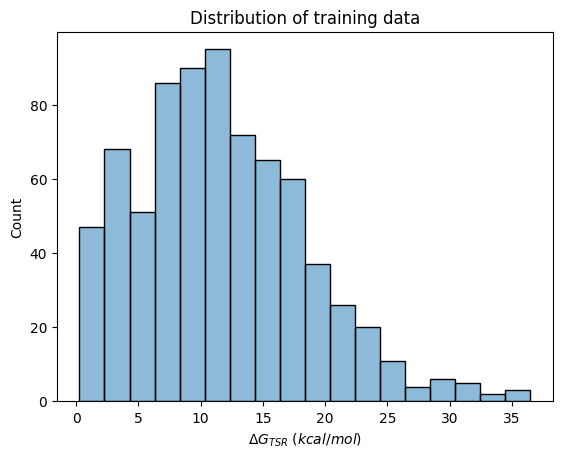

In [83]:
# Plot probability density of target variable for the full dataset
#sns.kdeplot(fill=True , data=yref_train, legend=False)
sns.histplot(fill=True , data=yref_train, legend=False)
#plt.title("Kernel density estimate for train set")
plt.title("Distribution of training data")
plt.xlabel("$ΔG_{TSR}$ $(kcal/mol)$")
plt.savefig("hist_train.png")

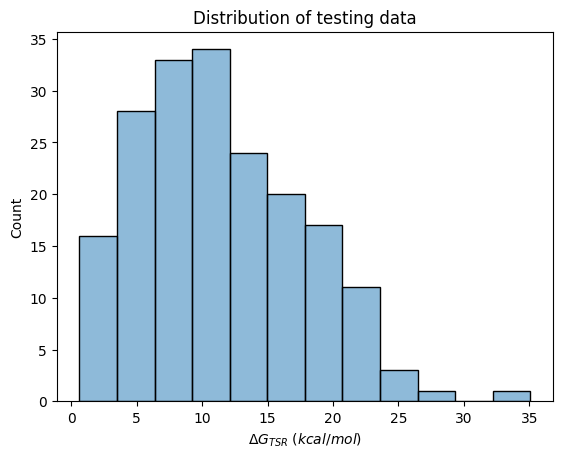

In [84]:
# Plot probability density of target variable for the full dataset
#sns.kdeplot(fill=True , data=yref_train, legend=False)
sns.histplot(fill=True , data=yref_test, legend=False)
#plt.title("Kernel density estimate for test set")
plt.title("Distribution of testing data")
plt.xlabel("$ΔG_{TSR}$ $(kcal/mol)$")
plt.savefig("hist_test.png")

In [ ]:
# Number of heavy atoms
#num_heavy_atoms = []
#for reaction_smiles in df["reaction_smiles"]:
#    reaction = AllChem.ReactionFromSmarts(reaction_smiles, useSmiles=True)
#    num_heavy_atoms_react = sum([reactant.GetNumHeavyAtoms() for reactant in reaction.GetReactants()])
#    num_heavy_atoms.append(num_heavy_atoms_react)
#num_heavy_atoms = pd.DataFrame(num_heavy_atoms)
#heavy_atoms_df = num_heavy_atoms.loc[test].copy()
#heavy_atoms_df.columns = ["no_heavy_atoms"]
#residuals = y[test] - preds_test
#heavy_atoms_df["residuals"] = residuals
#heavy_atoms_df["no_heavy_atoms"].plot.hist()
#plt.xlabel("Number of heavy atoms")
#heavy_atoms_df.plot.scatter("no_heavy_atoms", "residuals")
#plt.xlabel("No. heavy atoms")
#plt.ylabel("Residuals (kcal/mol)")
#mae_df = heavy_atoms_df.abs().groupby("no_heavy_atoms").mean()
#mae_df.index = mae_df.index.astype("int32")
#mae_df.plot.bar(legend=None)
#plt.ylabel("MAE (kcal/mol)")
#plt.xlabel("No. heavy atoms")

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


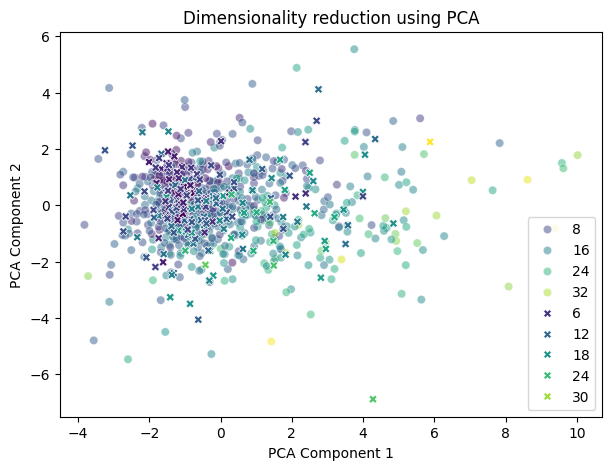

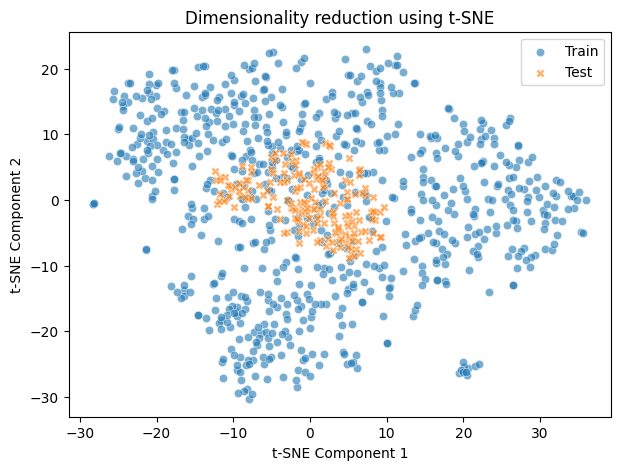

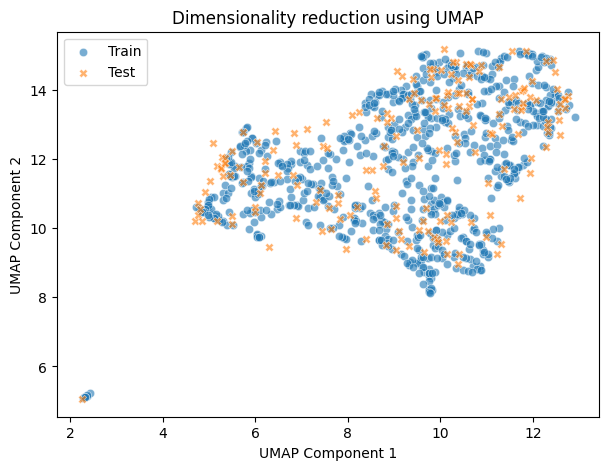

In [5]:
# Clustering plots for the dataset
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create the scatter plot with a continuous color range using "Spectral" palette
plt.figure(figsize=(7, 5))
scatter_train = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=yref_train.values.ravel(),  palette="viridis", alpha=0.5)
scatter_test = sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=yref_test.values.ravel(), palette="viridis", marker='X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Dimensionality reduction using PCA')
plt.savefig("dataset_pca.png")

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], label='Train', alpha=0.6)
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], label='Test', alpha=0.6, marker='X')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Dimensionality reduction using t-SNE')
plt.legend()
plt.show()

# Dimensionality reduction using UMAP
reducer = umap.UMAP()
X_train_umap = reducer.fit_transform(X_train)
X_test_umap = reducer.transform(X_test)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], label='Train', alpha=0.6)
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], label='Test', alpha=0.6, marker='X')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('Dimensionality reduction using UMAP')
plt.legend()
plt.show()

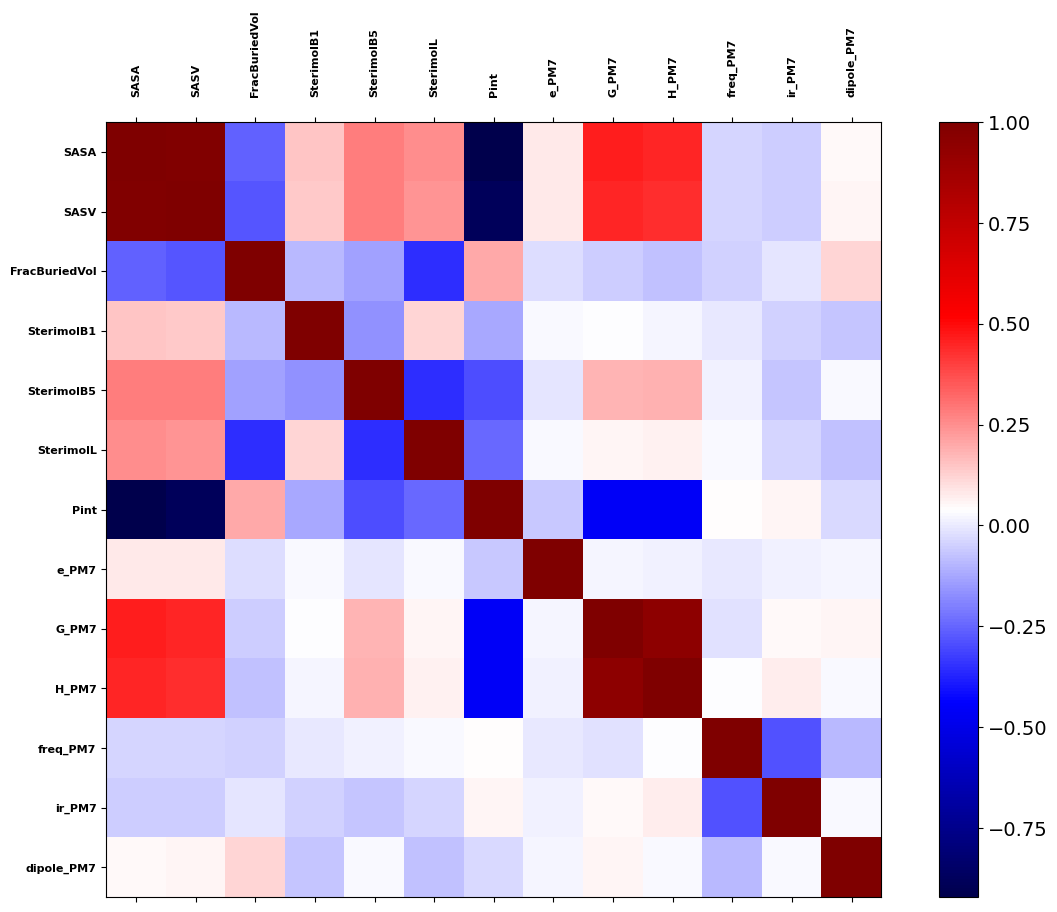

In [6]:
# Draw the heatmap with the mask and correct aspect ratio
corr = X.corr() # Calculate pairwise correlation among descriptors
f = plt.figure(figsize=(15,10))
plt.matshow(corr, fignum=f.number , cmap = plt.cm.seismic)
#plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=30, rotation=90)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=8, weight='bold', rotation=90)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=8, weight='bold')
plt.tick_params(axis='x', pad=15)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=28)
plt.savefig("correlation_matrix.png")

Text(0.5, 0, 'Feature')

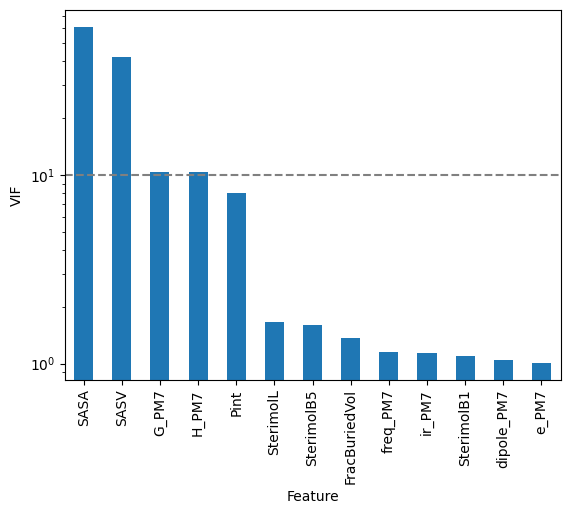

In [7]:
# Feature importance
vifs = pd.Series(np.linalg.inv(X.corr("pearson")).diagonal(), index=X.columns, name="VIF")
vifs.sort_values(ascending=False).plot.bar()
plt.yscale("log")
plt.axhline(10, linestyle="--", color="gray")
plt.ylabel("VIF")
plt.xlabel("Feature")

In [10]:
# 1D correlation with the features
#r = X.corrwith(yref)
#r.name = "Pearson"
#rho = X.corrwith(y, method="spearman")
#rho.name = "Spearman"
#tau = X.corrwith(y, method="kendall")
#tau.name = "Kendall"
#mi = mutual_info_regression(X, y)
#mi = pd.Series(mi, index=X.columns, name="Mutual information")
#df = pd.concat([r, rho, tau, mi], axis=1)
#df.plot.barh(figsize=figsize_default * np.array([1, 2]))
#plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.1))
#ranks = df.abs().rank(ascending=False)
#fix, ax = plt.subplots()
#ax.set_prop_cycle(cycler(color=plt.get_cmap('tab20').colors))

#x_range = np.arange(len(ranks.columns))
#for i, (name, values) in enumerate(ranks.sort_values(by="Pearson").iterrows()):
#    if np.any(values <= 10):
#        label = name
#    else:
#        label = '_nolegend_'
#    ax.plot(x_range, values, '-o', label=label)
#    #plt.plot(x_range, ranks.iloc[i], 'o', c=color, alpha=0.5)
#plt.ylim(0, 10.5)
#plt.yticks(range(1, 11))
#plt.xticks(x_range, labels=ranks.columns)
#plt.legend(loc="right", bbox_to_anchor=(1.5, 0.5))
#plt.ylabel("Rank")
#plt.xlabel("Metric")
##plt.figlegend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.1))
##plt.tight_layout()
#plt.show()

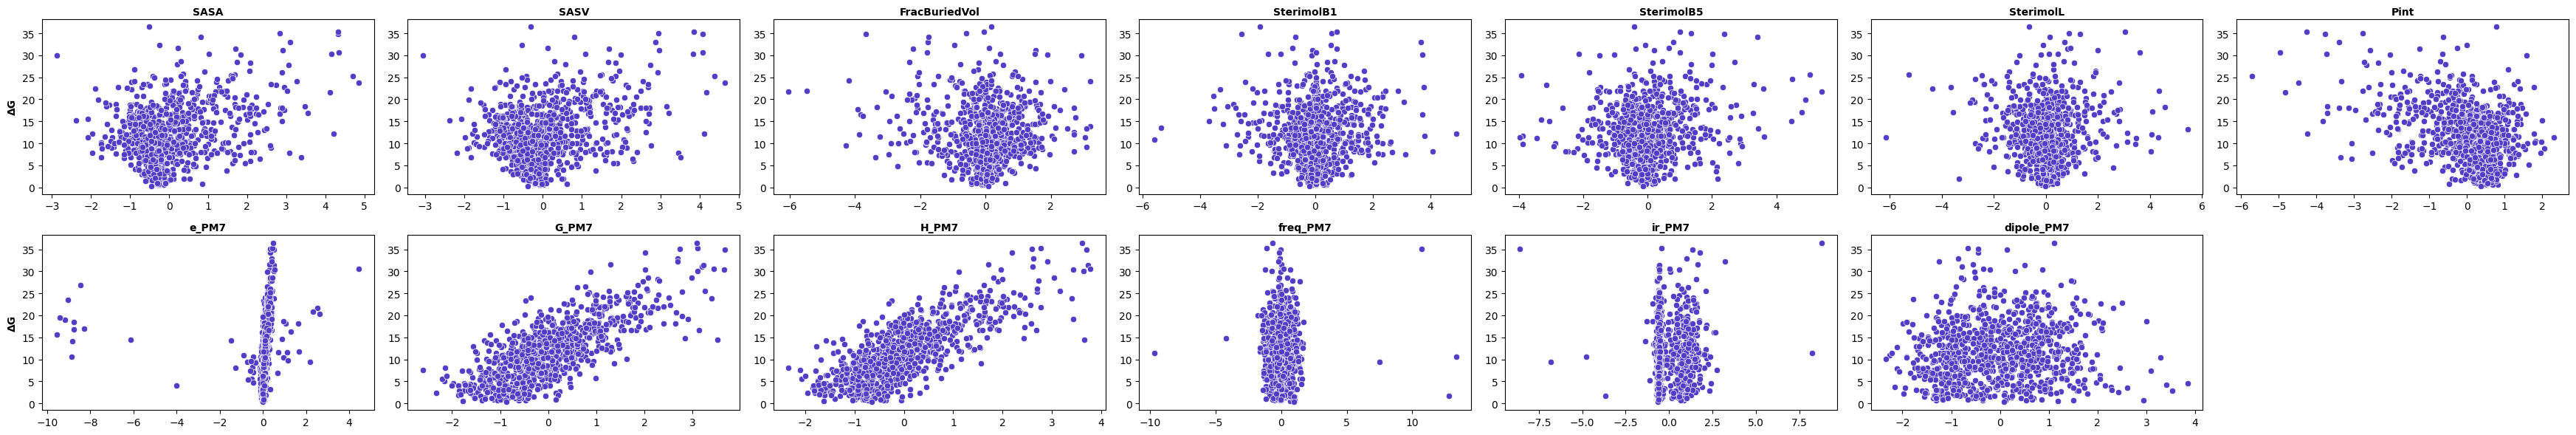

In [85]:
# Prepare DataFrame for pairplot subplots
plot_df = combined_df.drop(columns=['Datapoint', 'dGTSR_PM7', 'dGTSR_diff'])

# Plot scatter plots for each descriptor against the target
k = len(plot_df.columns) - 1  # Exclude the target variable
n_cols = 7
n_rows = (k - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

for i, name in enumerate(plot_df.columns[:-1]):  # Exclude the target variable
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    sns.scatterplot(x=plot_df[name], y=plot_df['dGTSR_refDZ'], ax=ax, color="xkcd:blue with a hint of purple", legend=False)
    ax.set_xlabel(name, fontweight='bold')
    ax.xaxis.set_label_position('top')
    if c == 0:
        ax.set_ylabel('ΔG', fontweight='bold')
    else:
        ax.set_ylabel('')
    ax.set_title('')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    if n_rows > 1:
        fig.delaxes(axes[r, c])
    else:
        fig.delaxes(axes[c])

fig.tight_layout(rect=[0.05, 0.05, 1, 1])

fig.tight_layout()
plt.savefig("descriptors_vs_target.png")

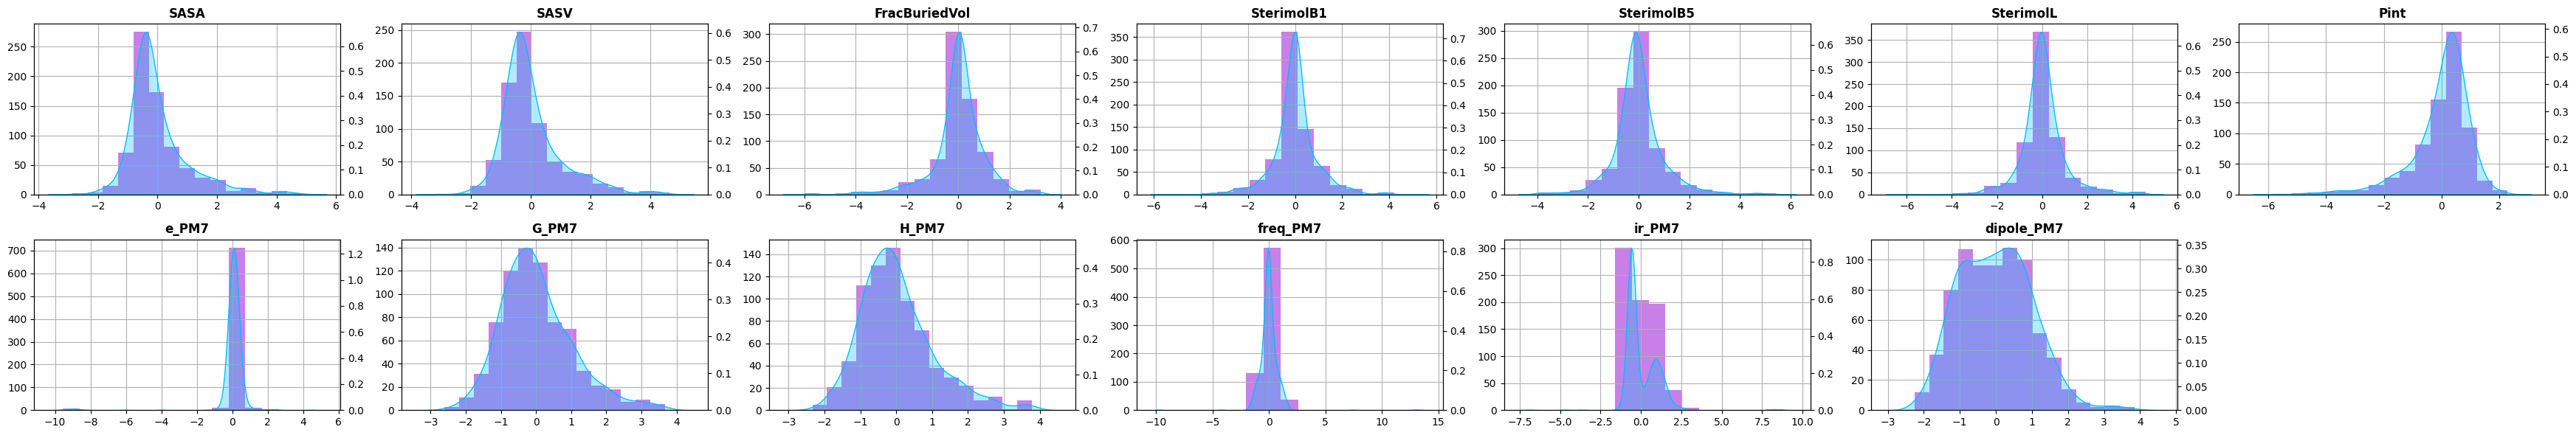

In [86]:
# Plot distribution of the descriptors for KDE
k = len(X_train.columns)
n_cols = 7
n_rows = (k - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

for i, (name, col) in enumerate(X_train.items()):
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]

    col.hist(ax=ax, color="darkviolet", alpha=0.5, bins=15)
    ax2 = ax.twinx()
    sns.kdeplot(data=col, ax=ax2, color="deepskyblue", fill=True, alpha=0.3)
    ax2.set_title(name, fontweight='bold')
    ax2.set_ylim(0)
    ax2.set_ylabel('')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    if n_rows > 1:
        fig.delaxes(axes[r, c])
    else:
        fig.delaxes(axes[c])

fig.tight_layout()
plt.savefig("descriptors_distribution.png")

In [87]:
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, PassiveAggressiveRegressor, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor

from warnings import simplefilter, filterwarnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
simplefilter('ignore', category=ConvergenceWarning)
#simplefilter('ignore', category=DataConversionWarning)
filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model._ridge')

from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [90]:
def fit_and_evaluate(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test):
    y_train = yref_train.values.ravel()
    y_test = yref_test.values.ravel()
    #y_train = ydiff_train.values.ravel()
    #y_test = ydiff_test.values.ravel()
    print(f"Fitting {model_name}...")
    if model_name == 'CatBoostRegressor':
        model = model_class(verbose=0)
    elif model_name == 'GaussianProcessRegressor':
        #kernel=ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
        kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
        alpha = 10.0
        model = model_class(kernel=kernel, alpha=alpha)
    else:
        model = model_class()
    model.fit(X_train, y_train)
    #joblib.dump(model, f'{model_name}_model.pkl')
    print(f"Model fitting complete for {model_name}.")
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"{model_name} Model Performance for ml:")
    print(f'Train set: R2= {train_r2}, MAE = {train_mae}, RMSE = {train_rmse}')
    print(f'Test set: R2 = {test_r2}, MAE = {test_mae}, RMSE = {test_rmse}')

    #y_train = yref_train.values.ravel()
    #y_test = yref_test.values.ravel()
    #ysqm_train = ysqm_train.values.ravel()
    #ysqm_test = ysqm_test.values.ravel()
    #y_train_pred = ysqm_train + model.predict(X_train)
    #y_test_pred = ysqm_test + model.predict(X_test)
    #train_method_r2 = r2_score(y_train, ysqm_train)
    #test_method_r2 = r2_score(y_test, ysqm_test)
    #train_r2 = r2_score(y_train, y_train_pred)
    #test_r2 = r2_score(y_test, y_test_pred)
    #train_method_mae = mean_absolute_error(y_train, ysqm_train)
    #test_method_mae = mean_absolute_error(y_test, ysqm_test)
    #train_mae = mean_absolute_error(y_train, y_train_pred)
    #test_mae = mean_absolute_error(y_test, y_test_pred)
    #train_method_rmse = np.sqrt(mean_squared_error(y_train, ysqm_train))
    #test_method_rmse = np.sqrt(mean_squared_error(y_test, ysqm_test))
    #train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    #test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    #print(f"Performance for PM7:")
    #print(f'Train set: R2= {train_method_r2}, MAE = {train_method_mae}, RMSE = {train_method_rmse}')
    #print(f'Test set: R2 = {test_method_r2}, MAE = {test_method_mae}, RMSE = {test_method_rmse}')
    #print(f"{model_name} Model Performance for ysqm+ml:")
    #print(f'Train set: R2= {train_r2}, MAE = {train_mae}, RMSE = {train_rmse}')
    #print(f'Test set: R2 = {test_r2}, MAE = {test_mae}, RMSE = {test_rmse}')
    
    return model

def run_grid_search(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test):
    y_train = yref_train.values.ravel()
    y_test = yref_test.values.ravel()
    #y_train = ydiff_train.values.ravel()
    #y_test = ydiff_test.values.ravel()
    param_grid = regressor_configs[model_name]
    print(f'Starting GridSearchCV for {model_name}...')
    if model_name == 'CatBoostRegressor':
        model = model_class(logging_level='silent')
    else:
        model = model_class()
    grid_search = GridSearchCV(model_class(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
   
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'{model_name}_model.pkl')
    return grid_search, best_model

def print_results(model_name, best_model, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test):
    y_train = yref_train.values.ravel()
    y_test = yref_test.values.ravel()
    print(f"GridSearchCV complete for {model_name}.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score (MAE): {-grid_search.best_score_}")
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    #y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
    #y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    #y_train = y_scaler.inverse_transform(y_train)
    #y_test = y_scaler.inverse_transform(y_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'{model_name} Model Performance:')
    print(f'Train set: R2= {train_r2}, MAE = {train_mae}, RMSE = {train_rmse}')
    print(f'Test set: R2 = {test_r2}, MAE = {test_mae}, RMSE = {test_rmse}')
    return y_train, y_train_pred, y_test, y_test_pred

def display_results(y_train, y_train_pred, y_test, y_test_pred):
    sns.set_style("white")
    plt.figure(figsize= (5,5))
    plt.xlabel("DFT Barrier Height $(kcal/mol)$" , fontsize = 14)
    plt.ylabel("ML Barrier Height $(kcal/mol)$" , fontsize = 14)
    plt.plot(y_train , y_train_pred , 'o' , color = "red" , markersize = 1 )
    plt.plot(y_test , y_test_pred , 'x' , color = "blue" , markersize = 1 )
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{model_name}_plot.png",bbox_inches='tight')
    return

In [91]:
regressor_configs = {
    'Ridge': {
        'alpha': [1e-1, 1, 10, 50],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'ElasticNet': {
        'alpha': [1e-1, 1, 10, 50],
        'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
        'selection': ['cyclic', 'random']
    },
    'BayesianRidge': {
        'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3]
    },
    'PassiveAggressiveRegressor': {
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'epsilon': [0, 0.25, 0.5, 0.75, 1]
    },
    'HuberRegressor': {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        'epsilon': [1.35, 1.5, 1.75, 2]
    },
    'KNeighborsRegressor': {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'RandomForestRegressor': {
        #'n_estimators': [10, 50, 100, 200, 500, 1000],
        'max_depth': [1, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        #'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-3, 1e-2, 1e-1, 1],
        'max_depth': [1, 3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'ExtraTreesRegressor': {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'max_depth': [1, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
       'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostRegressor': {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'loss': ['linear', 'square', 'exponential']
    },
    'DecisionTreeRegressor': {
        'max_depth': [1, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'SVR': {
        'C': [1e-1, 1, 5, 10],
        'epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['auto', 'scale'],
        'degree': [2, 3, 4],
        'coef0': [0, 0.5, 1]
    },
    'KernelRidge': {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        'kernel': ['linear', 'rbf', 'laplacian', 'polynomial', 'sigmoid'],
        #'gamma': ['auto', 'scale'],
        #'degree': [2, 3, 4],
        #'coef0': [0, 0.5, 1]
    },
    'GaussianProcessRegressor': {
        'alpha': [1, 10, 20],
        #'n_restarts_optimizer': [10, 20, 50],
        'kernel': [
            1.0 * RBF(length_scale=1.0),
            1.0 * Matern(length_scale=1.0, nu=1.5),
            1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
            1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0),
            1.0 * DotProduct(sigma_0=1.0) + WhiteKernel(noise_level=1.0),
            ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)            
        ],
    },
    'XGBRegressor': {
        #'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-3, 1e-2, 1e-1, 1],
        'max_depth': [1, 3, 5, 7, 9],
        'subsample': [0.5, 0.75, 1.0],
        'colsample_bytree': [0.5, 0.75, 1.0],
        'min_child_weight': [1, 5, 10]
    },
    'LGBMRegressor': {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_depth': [1, 3, 5, 7, 9],
        'num_leaves': [31, 63, 127],
        'feature_fraction': [0.5, 0.75, 1.0],
        'bagging_fraction': [0.5, 0.75, 1.0]
    },
    'CatBoostRegressor': {
        #'iterations': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [1e-2, 1e-1],
        #'depth': [1, 3, 5, 7, 9],
        #'l2_leaf_reg': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        #'border_count': [32, 64, 128]
    },
    'NGBRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'minibatch_frac': [0.5, 0.75, 1.0],
        'natural_gradient': [True, False]
    }
}

models = {
    #'Ridge': Ridge,
    'ElasticNet': ElasticNet, #Select
    #'BayesianRidge': BayesianRidge,
    #'PassiveAggressiveRegressor': PassiveAggressiveRegressor,
    #'HuberRegressor': HuberRegressor,
    #'KNeighborsRegressor': KNeighborsRegressor,
    'RandomForestRegressor': RandomForestRegressor, #Select
    'GradientBoostingRegressor': GradientBoostingRegressor,#Select
    #'ExtraTreesRegressor': ExtraTreesRegressor,
    #'AdaBoostRegressor': AdaBoostRegressor,
    #'DecisionTreeRegressor': DecisionTreeRegressor,
    'SVR': SVR, #Select
    #'KernelRidge': KernelRidge,
    'GaussianProcessRegressor': GaussianProcessRegressor, #select
    'XGBRegressor': XGBRegressor, #Select
    #'LGBMRegressor': LGBMRegressor, 
    #'CatBoostRegressor': CatBoostRegressor,
    #'NGBRegressor': NGBRegressor
}

Starting GridSearchCV for ElasticNet...


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.592e+03, tolerance: 2.709e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.465e+03, tolerance: 2.731e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.l

GridSearchCV complete for ElasticNet.
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.25, 'selection': 'random'}
Best cross-validation score (MAE): 3.335145713250779
ElasticNet Model Performance:
Train set: R2= 0.6215780037313464, MAE = 3.282901473841182, RMSE = 4.134499723299294
Test set: R2 = 0.5797387708652524, MAE = 3.078579674614441, RMSE = 4.054098389498732
Starting GridSearchCV for RandomForestRegressor...
GridSearchCV complete for RandomForestRegressor.
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation score (MAE): 2.9388711954897873
RandomForestRegressor Model Performance:
Train set: R2= 0.9326020647179242, MAE = 1.300062047230659, RMSE = 1.7448499169902254
Test set: R2 = 0.6515766689313682, MAE = 2.8258906797199552, RMSE = 3.691375585451137
Starting GridSearchCV for GradientBoostingRegressor...


/tmp/ipykernel_11896/2351213145.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


GridSearchCV complete for GradientBoostingRegressor.
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score (MAE): 2.877798716362848
GradientBoostingRegressor Model Performance:
Train set: R2= 0.9768338627056281, MAE = 0.8003298982168505, RMSE = 1.0229669292197798
Test set: R2 = 0.6465394489029687, MAE = 2.868969423956045, RMSE = 3.7179632815604275
Starting GridSearchCV for SVR...


/tmp/ipykernel_11896/2351213145.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


GridSearchCV complete for SVR.
Best parameters: {'C': 10, 'coef0': 0, 'degree': 2, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score (MAE): 3.244942500041571
SVR Model Performance:
Train set: R2= 0.8023987884360824, MAE = 2.141998678949391, RMSE = 2.9876490613329656
Test set: R2 = 0.5842459553361701, MAE = 3.0734928665638446, RMSE = 4.032300249943773


/tmp/ipykernel_11896/2351213145.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


Starting GridSearchCV for GaussianProcessRegressor...


/opt/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: Conv

GridSearchCV complete for GaussianProcessRegressor.
Best parameters: {'alpha': 10, 'kernel': 1**2 * RationalQuadratic(alpha=0.1, length_scale=1)}
Best cross-validation score (MAE): 3.073925999020193
GaussianProcessRegressor Model Performance:
Train set: R2= 0.8581810171768807, MAE = 2.013175220541717, RMSE = 2.531057223726262
Test set: R2 = 0.6095356295927152, MAE = 2.9290510419123716, RMSE = 3.9077369978643888


/tmp/ipykernel_11896/2351213145.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


Starting GridSearchCV for XGBRegressor...
GridSearchCV complete for XGBRegressor.
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.75}
Best cross-validation score (MAE): 2.830361324393168
XGBRegressor Model Performance:
Train set: R2= 0.8624884737026227, MAE = 1.9659461743181401, RMSE = 2.492323039842781
Test set: R2 = 0.6440281082375923, MAE = 2.824331884612429, RMSE = 3.731147986349654


/tmp/ipykernel_11896/2351213145.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


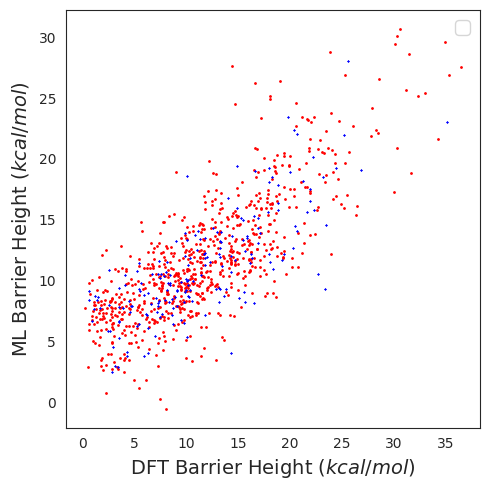

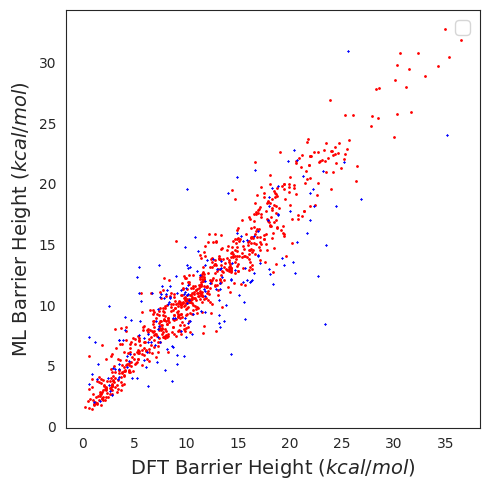

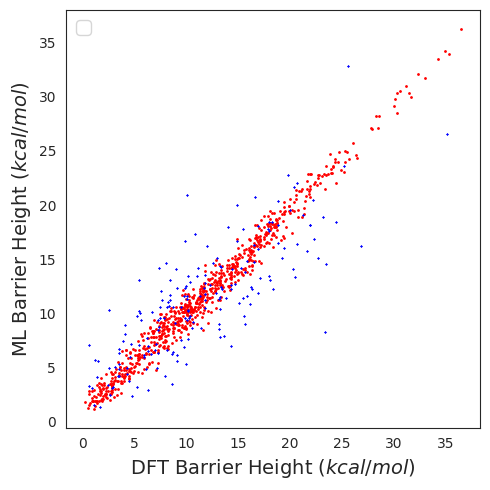

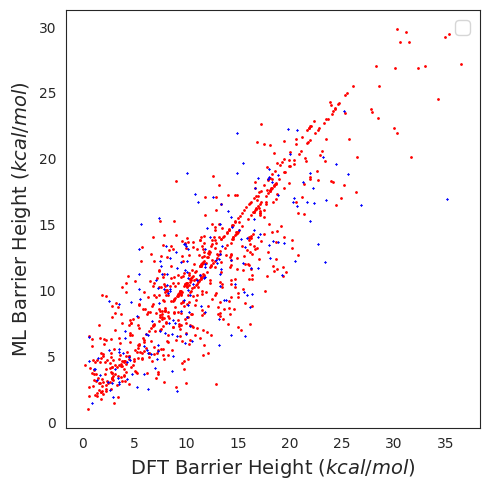

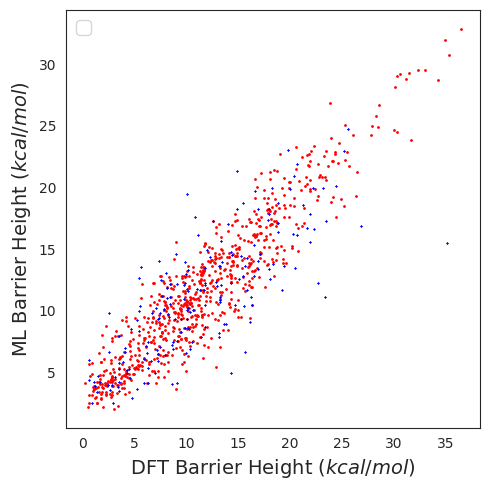

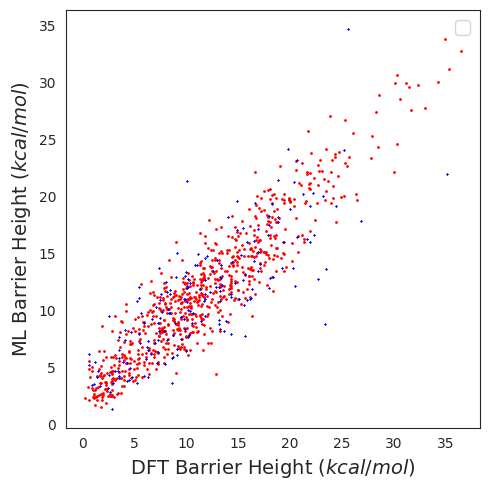

In [92]:
for model_name, model_class in models.items():
    #best_model = fit_and_evaluate(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test)
    grid_search, best_model = run_grid_search(model_name, model_class, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test)
    y_train, y_train_pred, y_test, y_test_pred = print_results(model_name, best_model, X_train, X_test, ydiff_train, ydiff_test, yref_train, yref_test, ysqm_train, ysqm_test)
    display_results(y_train, y_train_pred, y_test, y_test_pred)

In [11]:
# Plots for prediction results
def plot_df(dft , mopac , preds):
     sns.set_style("white")
     mae = mean_absolute_error(dft, preds)
     mae_or = mean_absolute_error(dft , mopac)
     fig , (ax1 , ax2)  = plt.subplots(2,1 , figsize= (10,12))
     ax1.set_xlabel("PM7 Barrier Height $(kcal/mol)$" , fontsize = 14)
     ax1.set_ylabel("DFT Barrier Height $(kcal/mol)$" , fontsize = 14)
     ax2.set_xlabel("ML Barrier Height $(kcal/mol)$" , fontsize = 14)
     ax2.set_ylabel("DFT Barrier Height $(kcal/mol)$" , fontsize = 14)
     ax1.plot(mopac , dft , 'o' , color = "indianred" , markersize = 1 )
     ax2.plot(preds , dft , 'o' , color = "indianred" , markersize = 1 )
     ax1.text(125.5,20, "MAE= %.1f $(kcal/mol)$" %mae_or ,style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
     ax2.text(100.5,32.5, "MAE= %.1f $(kcal/mol)$" %mae ,style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
     ax1.set_ylim(np.min(mopac),np.max(mopac))
     ax2.set_ylim(np.min(preds),np.max(preds))
     lims1 = [np.min([ax1.get_xlim(), ax1.get_ylim()]),  np.max([ax1.get_xlim(), ax1.get_ylim()])]
     my_suptitle = fig.suptitle("DFT vs PM7 vs ML comparison" , fontsize = 22 , y = 1.05)
     ax1.plot(lims1, lims1, 'k-', alpha=0.75, zorder=0 , linewidth = 2 , label = "$y=x$")
     ax1.set_aspect('equal')
     ax1.set_xlim(lims1)
     ax1.set_ylim(lims1)
     lims2 = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  np.max([ax2.get_xlim(), ax2.get_ylim()])]
     ax2.plot(lims2, lims2, 'k-', alpha=0.75, zorder=0 , linewidth = 2 , label = "$y=x$")
     ax2.set_aspect('equal')
     ax2.set_xlim(lims2)
     ax2.set_ylim(lims2)
     ax1.legend(fontsize=14)
     ax2.legend(fontsize=14)
     plt.tight_layout()
     #plt.savefig("xgb_preds_vert.pdf" ,  dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[my_suptitle])
     return

def PlotCorr(ae_dft , ae_mopac , ae_corr):
     sns.set_style("darkgrid")
     fig , (ax1 , ax2)  = plt.subplots(1,2 , figsize= (8,6))
     mae = mean_absolute_error(ae_dft, ae_corr)
     mae_or = mean_absolute_error(ae_dft , ae_mopac)
     fig.suptitle("DFT vs PM7 comparison + DL correction")
     ax1.plot(ae_mopac , ae_dft , "o" , color = "deeppink" , alpha=0.7)
     ax1.plot([np.min(ae_mopac),np.max(ae_mopac)] , [np.min(ae_dft) , np.max(ae_dft)] , "-k" , linewidth=4)
     ax1.set_xlabel("$E_{a}^{PM7}$ $(kcal/mol)$")
     ax1.set_ylabel("$E_{a}^{DFT}$ $(kcal/mol)$")
     ax1.text(30,165, "MAE= %.2f $(kcal/mol)$" %mae_or ,style='italic',
     bbox={'facecolor': 'gold', 'alpha': 0.5, 'pad': 10})
     ax2.plot(ae_corr , ae_dft , "o" , color = "deepskyblue" , alpha=0.7)
     ax2.plot([np.min(ae_corr),np.max(ae_corr)] , [np.min(ae_dft) , np.max(ae_dft)] , "-k" , linewidth=4)
     ax2.set_xlabel("$E_{a}^{PM7+DL}$ $(kcal/mol)$")
     ax2.text(40,165, "MAE= %.2f $(kcal/mol)$" %mae ,style='italic',
     bbox={'facecolor': 'gold', 'alpha': 0.5, 'pad': 10})
     plt.savefig("ea_preds_nn.pdf")
     return

def DensPlot(ae_dft , ae_mopac , ae_corr):
     fig = plt.figure(figsize = (8,6))
     ax = fig.add_subplot(1, 1, 1, projection='scatter_density' )
     ax.grid(False)
     density = ax.scatter_density(ae_corr, ae_dft , cmap=plt.cm.viridis )
     ax.set_xlabel("$E_{a}^{PM7+DL}$ $(kcal/mol)$")
     ax.set_ylabel("$E_{a}^{DFT}$ $(kcal/mol)$")
     fig.colorbar(density, label='Count')
     plt.savefig("dens_nn.pdf")
     return

In [ ]:
plot_df(y_test['dGTSR_PM7'].values, X_test[].values , preds_xg)
#PlotCorr(y_test["ae_diff"].values , X_test["AE_mopac"].values , y_preds[:,1])
#DensPlot(y_test["ae_diff"]##.values, X_test["AE_mopac"].values , y_preds[:,1])

In [ ]:
# Y-scrambling test
for scoring_function in scoring_functions:
    print(scoring_function.name)
    true_score, permutation_scores, p_value = permutation_test_score(best_estimator, X, y, cv=cv_folds, n_permutations=10, scoring=make_scorer(scoring_function.function), random_state=1)
    permutation_score_avg = np.mean(permutation_scores)
    print("True score:", true_score)
    print("Permutation score average:", permutation_score_avg)

In [ ]:
# Learning curves
train_size, train_scores_all, test_scores_all = learning_curve(est_gpr_matern_3_2, X_no_ts, activation_energy, cv=RepeatedKFold(10, 1, random_state=1), shuffle=True,
               train_sizes=np.linspace(0.1, 1.0, 10), scoring=make_scorer(mean_absolute_error), random_state=1, n_jobs=-1)
train_scores = train_scores_all.mean(axis=1)
test_scores = test_scores_all.mean(axis=1)
train_standard_errors = scipy.stats.sem(train_scores_all, axis=1)
test_standard_errors = scipy.stats.sem(test_scores_all, axis=1)
plt.plot(train_size, train_scores, label="Train")
plt.fill_between(train_size, train_scores - train_standard_errors, train_scores + train_standard_errors, alpha=0.1)
plt.plot(train_size, test_scores, label="Test")
plt.fill_between(train_size, test_scores - test_standard_errors, test_scores + test_standard_errors, alpha=0.1)
plt.legend()
plt.xlabel("Training samples")
plt.ylabel("MAE (kcal/mol)")
#plt.ylim(0, 1)

# Check the effect of different features sets on learning
feature_sets = [("Full", clone(est_gpr_matern_3_2), X), ("Small", clone(est_gpr_matern_3_2), X_s), ("No TS", clone(est_gpr_matern_3_2), X_no_ts), ("BERT", clone(est_gpr_matern_3_2_cat), X_bert_pt)]
results = {}
for name, estimator, X_ in feature_sets:
    print(name)
    train_size, train_scores_all, test_scores_all = learning_curve(estimator, X_, y, cv=RepeatedKFold(10, 1, random_state=1), shuffle=True,
               train_sizes=np.linspace(0.1, 1.0, 10), scoring=make_scorer(mean_absolute_error), random_state=1, n_jobs=-1)
    results[name] = {"scores": test_scores_all.mean(axis=1), "standard_errors": scipy.stats.sem(test_scores_all, axis=1)}
    for name in ["Full", "Small", "No TS", "BERT"]:
    scores = results[name]["scores"]
    standard_errors = results[name]["standard_errors"]
    plt.plot(train_size, scores, label=name)
    plt.fill_between(train_size, scores - standard_errors, scores + standard_errors, alpha=0.1)
plt.axhline(1.0, linestyle="--", color="k", label="Chemical accuracy")
plt.legend()
plt.xlabel("Traing samples")
plt.ylabel("MAE (kcal/mol)")
#plt.title("Learning curve for GPR with different features sets")

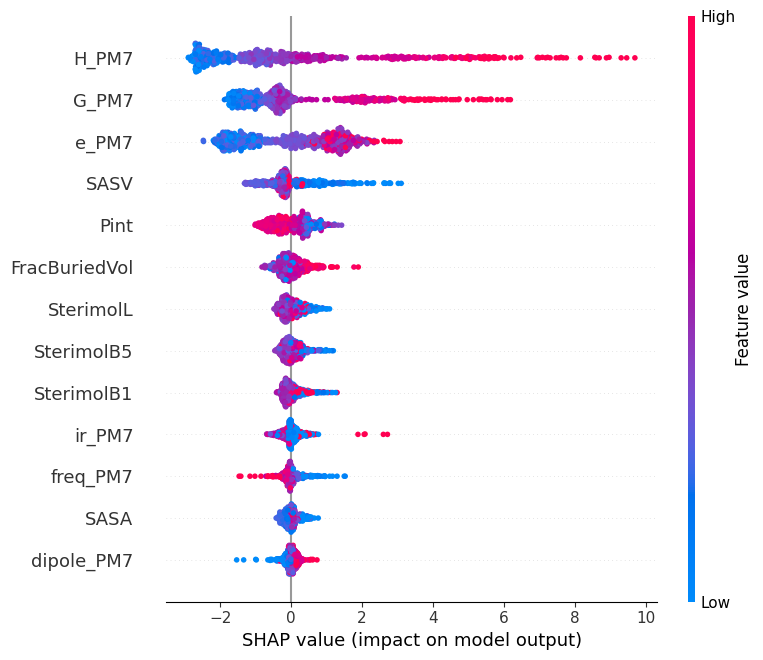

In [25]:
# SHAP feature importances
import shap
best_model = joblib.load('RandomForestRegressor_model.pkl')
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

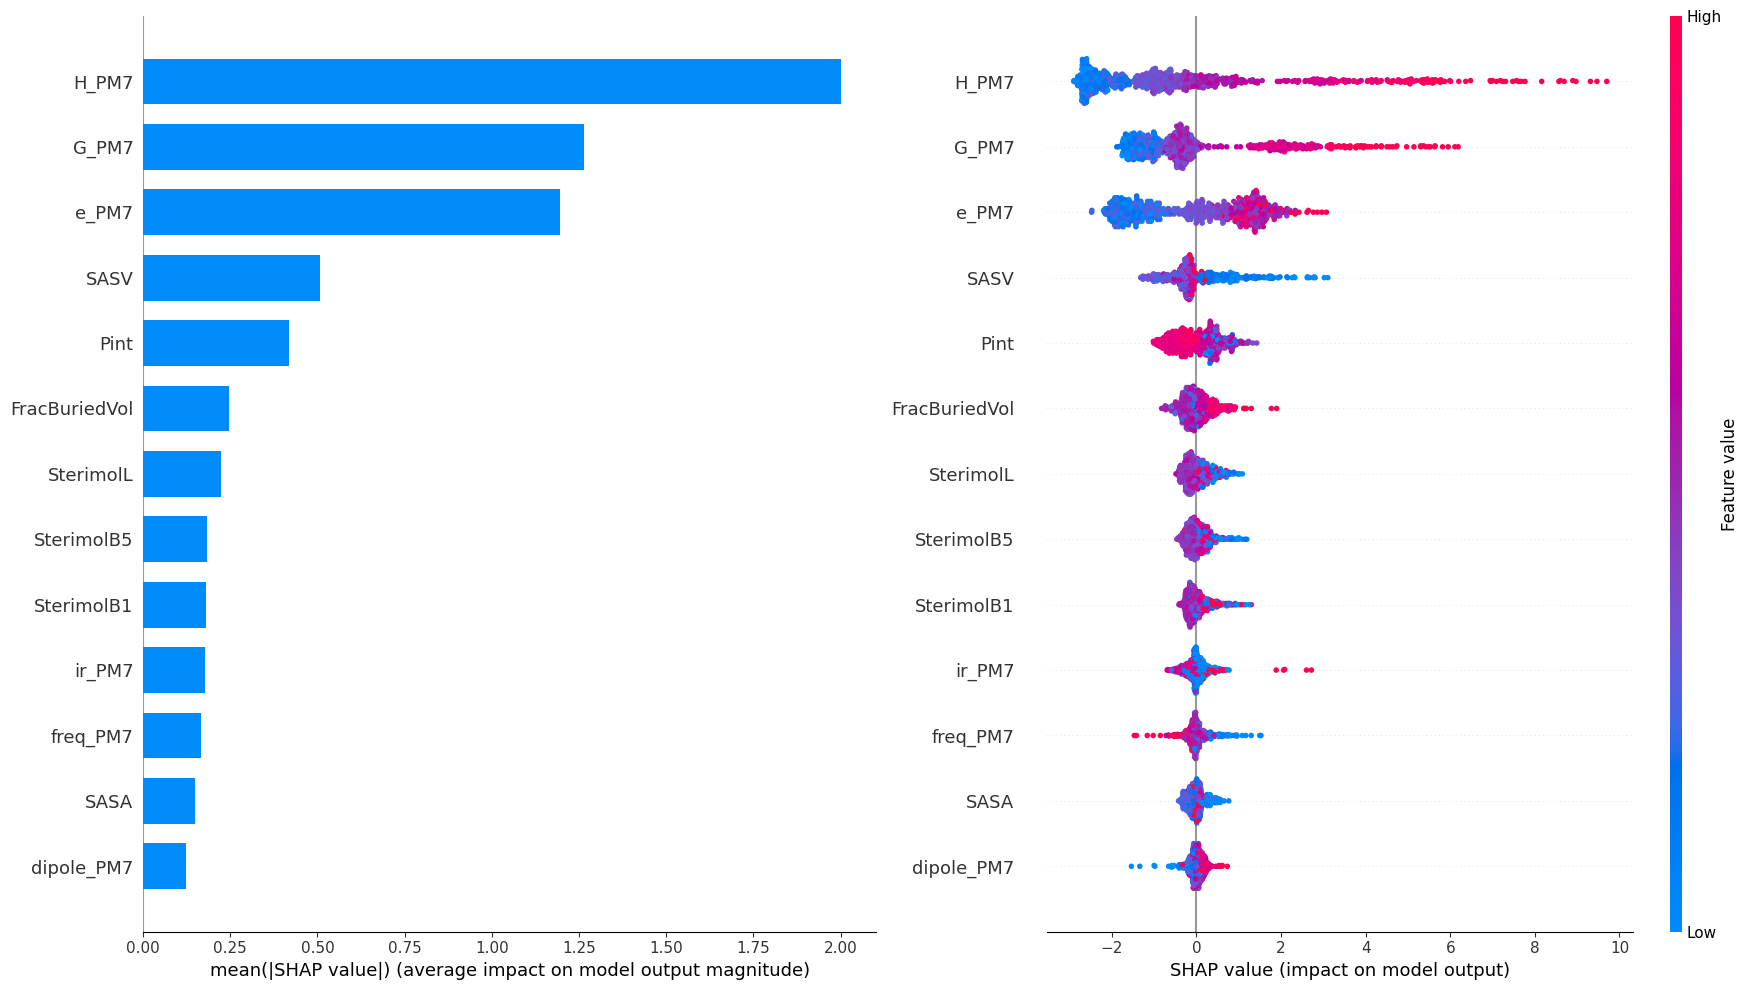

In [29]:
shap_values = explainer.shap_values(X_train)
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values, X_train, plot_type = 'bar', show=False, plot_size=None)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_train, show = False, plot_size=None)
plt.tight_layout()

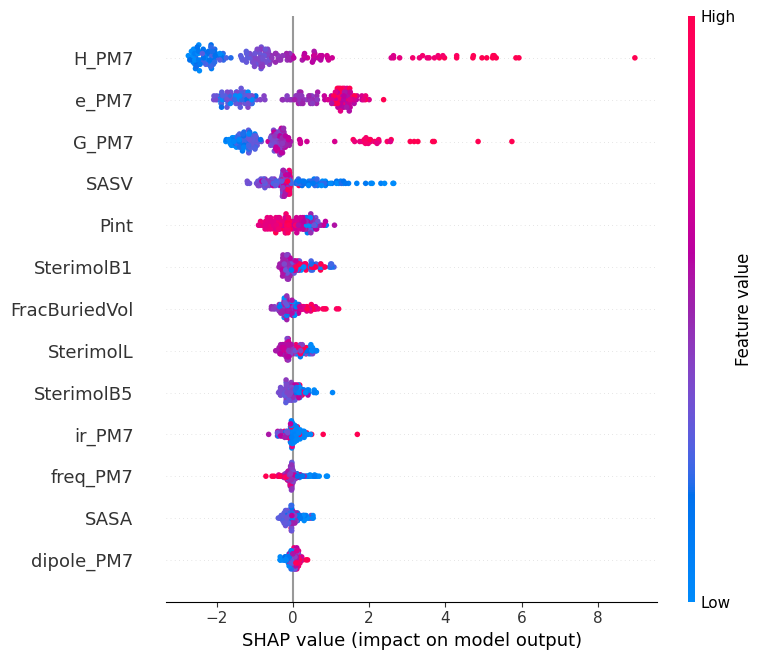

In [26]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

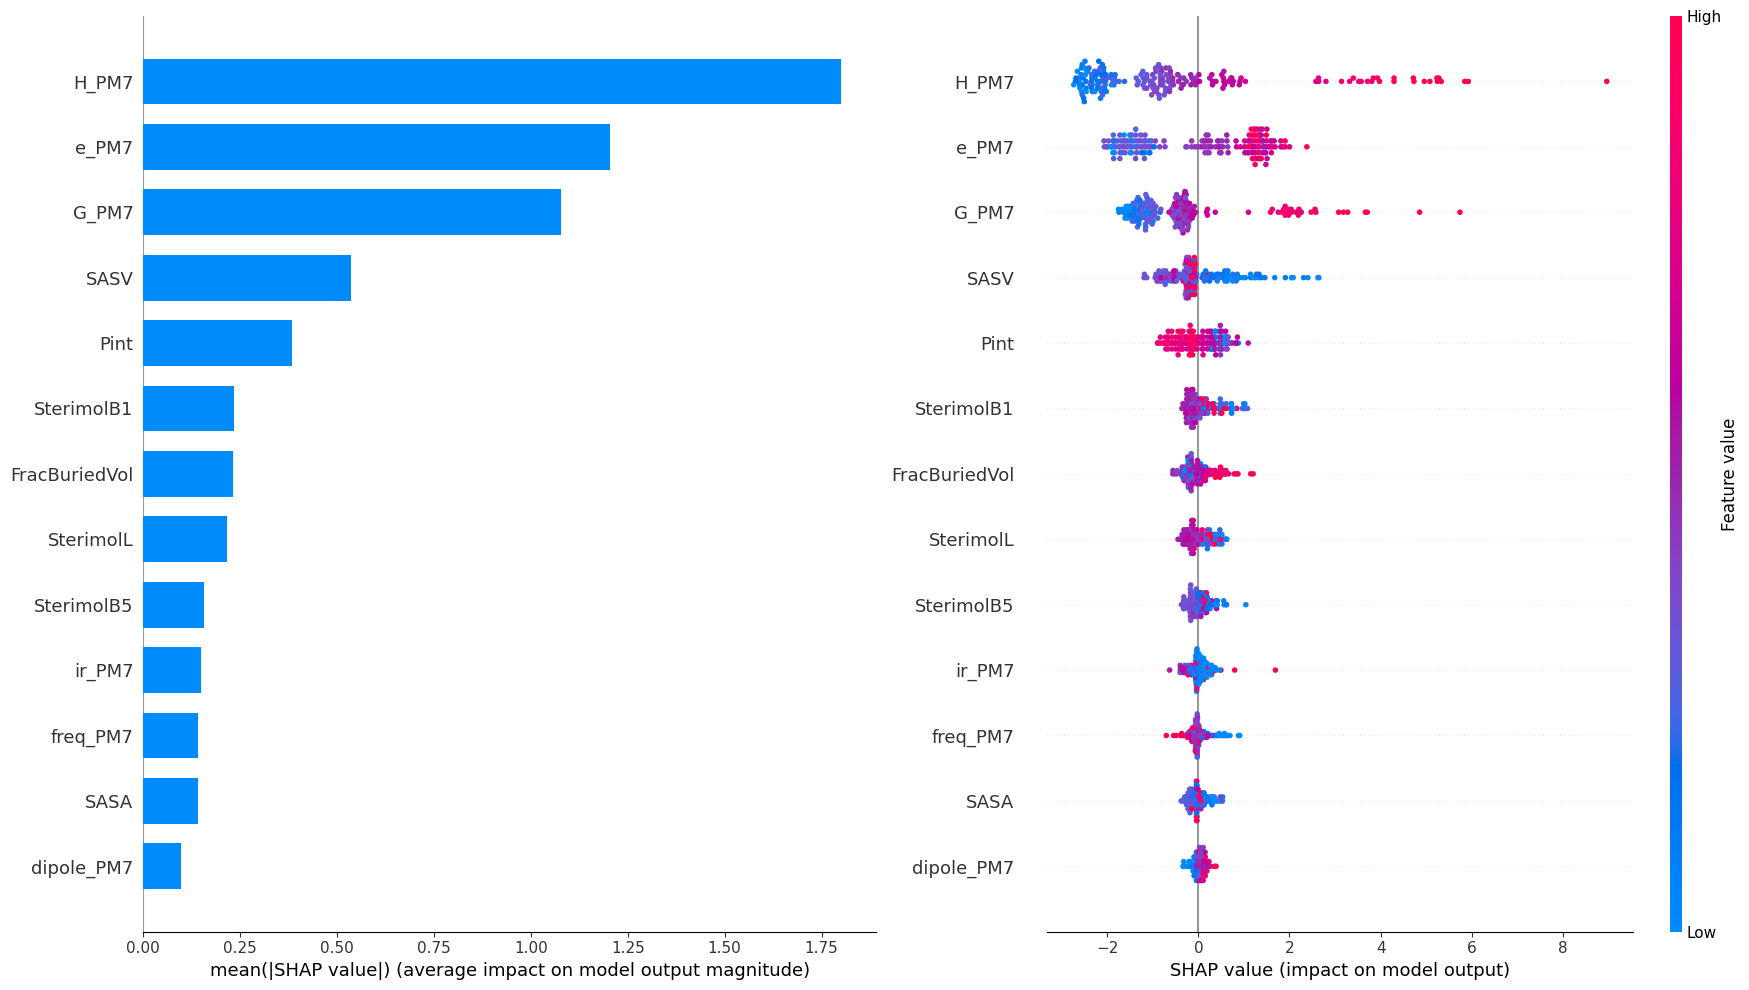

In [30]:
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values, X_test, plot_type = 'bar', show=False, plot_size=None)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, show = False, plot_size=None)
plt.tight_layout()

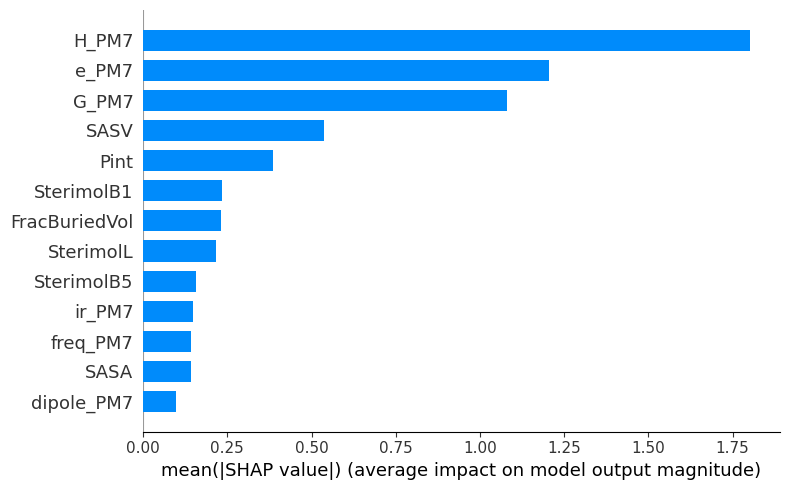

In [39]:
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, X_test, plot_type = 'bar', show=False, plot_size=None)
plt.tight_layout()
plt.savefig("descriptors_SHAP.png")